Metric of Interest: Mean Squared Log Error

The Goal: Forecast the Store Sales for each Store for next two months.


In [218]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
import pandas as pd 
import numpy as np 

In [219]:
train = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/Kaggle/womart_nutition_store/nutrition_store_fcst/TRAIN.csv',
           parse_dates=['Date'])

test = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/Kaggle/womart_nutition_store/nutrition_store_fcst/TEST_FINAL.csv',
           parse_dates=['Date'])

samp_submission = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/Kaggle/womart_nutition_store/nutrition_store_fcst/SAMPLE.csv')

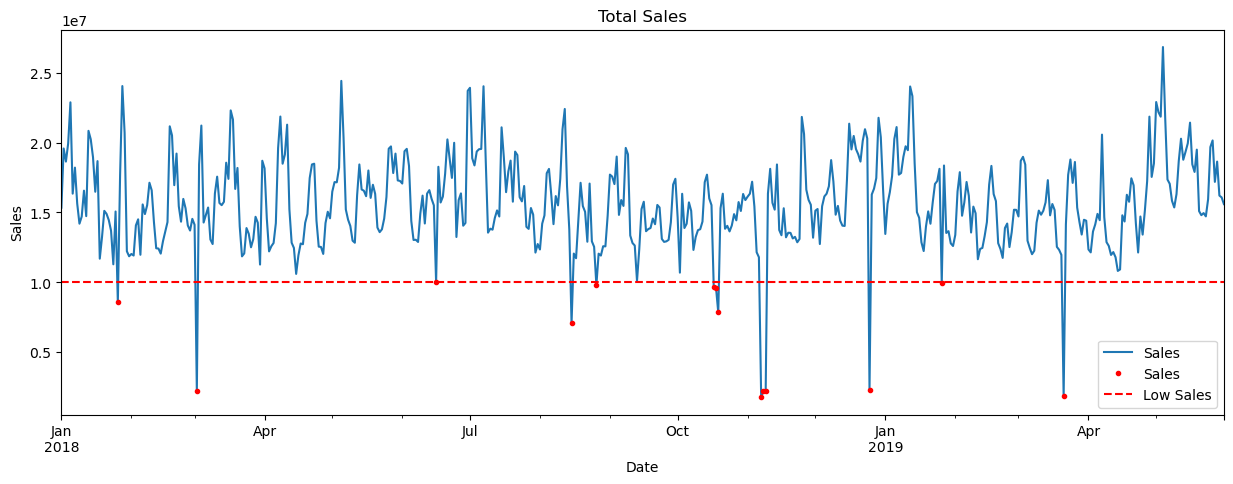

In [220]:
ax = train.resample('d',on='Date')[['Sales']].sum().plot(title="Total Sales",
                                                   xlabel='Date',
                                                   ylabel='Sales',
                                                   figsize=(15,5),
                                                   grid=True)

#plot low sales periods, the red line is completely heuristic, also
low_sales = train.resample('d',on='Date')[['Sales']].sum().query('Sales < 10000000')

low_sales.plot(color='r',
              marker='.',
              linestyle=' ',
              ax=ax)

ax.axhline(1e7,linestyle='--',color='red',label='Low Sales')

plt.legend()

In [221]:
low_sales.assign(dow = low_sales.index.dayofweek) # no pattern is found when looking at day of week 

train.set_index('Date').loc[low_sales.index].groupby('Store_Type')["Sales"].mean() # store types 1,2 sold considerably less

Store_Type
S1    14570.321150
S2    10697.976811
S3    18359.480714
S4    23201.949173
Name: Sales, dtype: float64

In [222]:
sales_ = train.set_index('Date').loc[low_sales.index,['#Order','Sales']].describe()

norm_sales = train.set_index('Date').loc[~train.index.isin(low_sales.index),['#Order','Sales']].describe()

sales_.join(norm_sales,rsuffix='_norm')

#Order         Sales    #Order_norm     Sales_norm
count  5110.000000   5110.000000  188340.000000  188340.000000
mean     28.377495  16579.206822      68.205692   42784.327982
std      22.036149  12144.744071      30.467415   18456.708302
min       0.000000      0.000000       0.000000       0.000000
25%       9.000000   5659.260000      48.000000   30426.000000
50%      25.000000  14895.765000      63.000000   39678.000000
75%      42.000000  24575.925000      82.000000   51909.000000
max     178.000000  83248.530000     371.000000  247215.000000

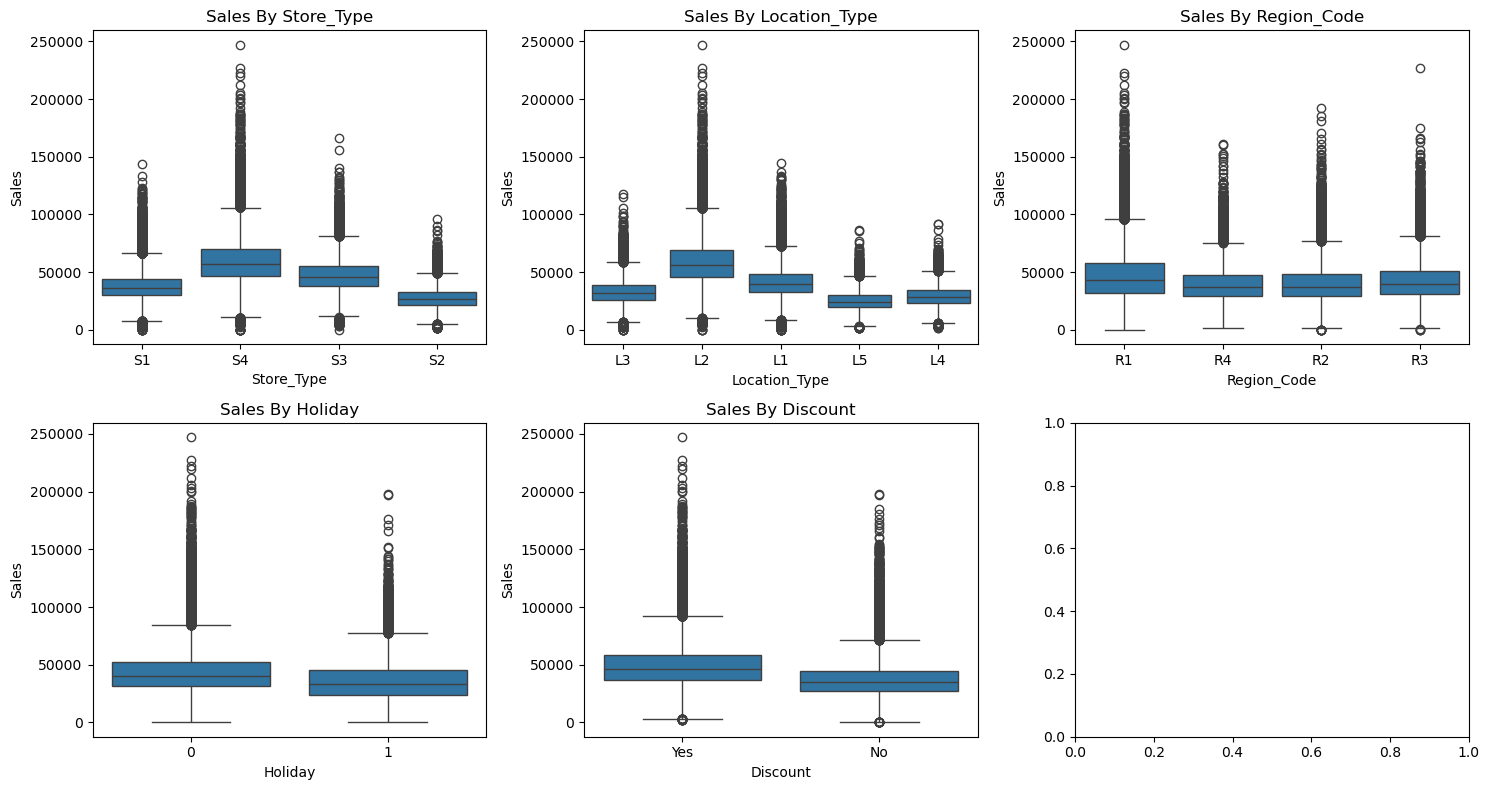

In [223]:
# lets look at sales differences in store type, location type, region code, holidays and discounts

feats = ['Store_Type','Location_Type','Region_Code','Holiday','Discount']

fig, ax = plt.subplots(figsize=(15,8),
                      ncols=3,
                      nrows=(len(feats) + 1)//3)

ax = ax.flatten() 

for i, feat in enumerate(feats): 
    
    box = sns.boxplot(data=train,
               x=feat,
               y='Sales',
               ax=ax[i]).set_title(f'Sales By {feat}')
    
plt.tight_layout()

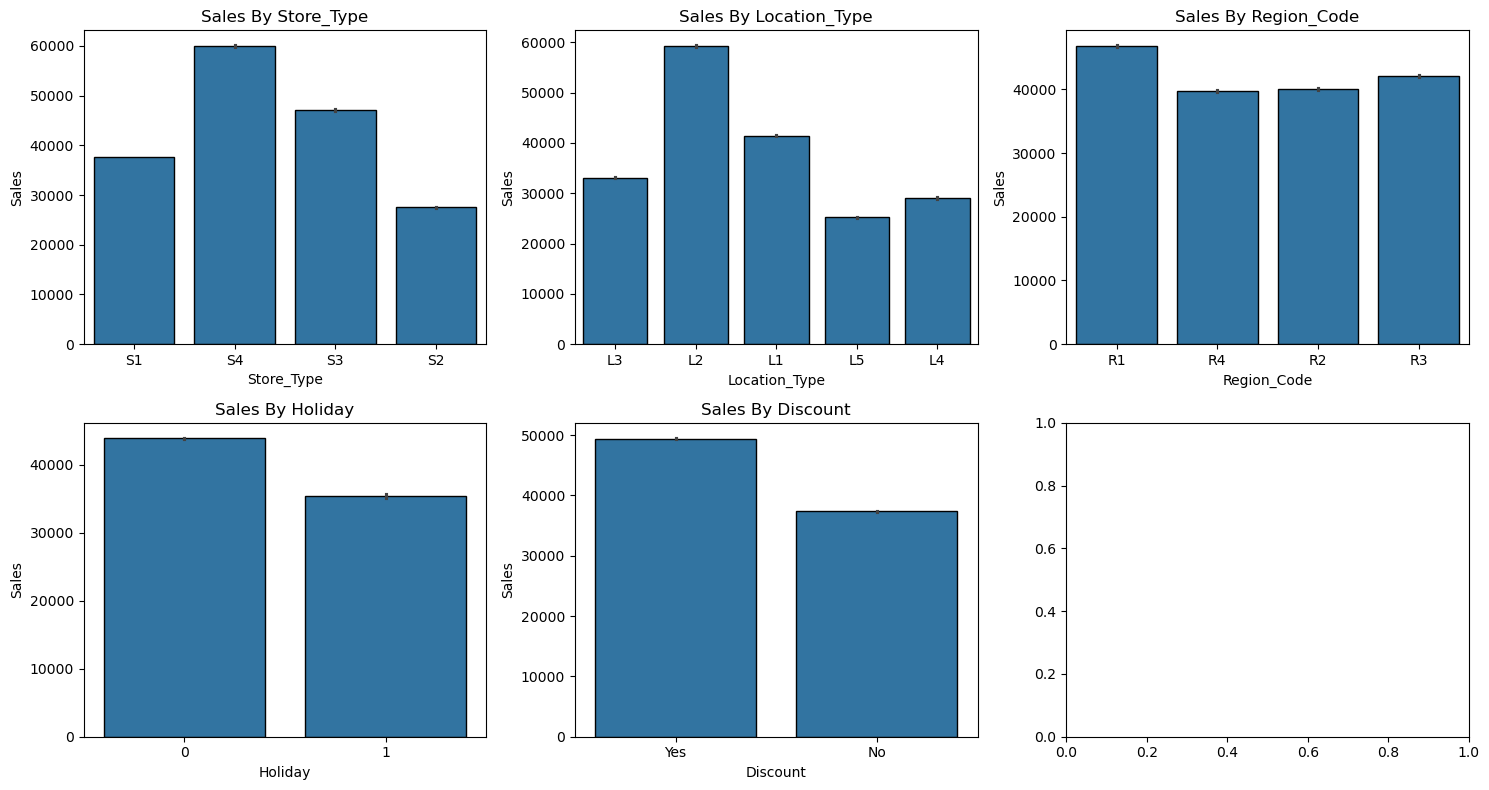

In [224]:
# lets look at sales differences in store type, location type, region code, holidays and discounts

feats = ['Store_Type','Location_Type','Region_Code','Holiday','Discount']

fig, ax = plt.subplots(figsize=(15,8),
                      ncols=3,
                      nrows=(len(feats) + 1)//3)

ax = ax.flatten() 

for i, feat in enumerate(feats): 
    
    box = sns.barplot(data=train,
               x=feat,
               y='Sales',
               ax=ax[i],
                     edgecolor='black').set_title(f'Sales By {feat}')
    
plt.tight_layout()

In [225]:
# it looks like we need to model discounts, holidays and select store types/regions but R2,3,4 and L3,4,5 aren't significantly different to the naked eye. 


#make datetime features and plot to examine seasonal patterns 
from feature_engine.datetime import DatetimeFeatures

dt_transformer = DatetimeFeatures(variables=['Date'],
                features_to_extract=['day_of_week','weekend','month','year','week','day_of_month','quarter'])


dtf_tab = dt_transformer.fit_transform(train).iloc[:,8:].set_index(train.Date)

In [226]:
import warnings 

warnings.filterwarnings('ignore')

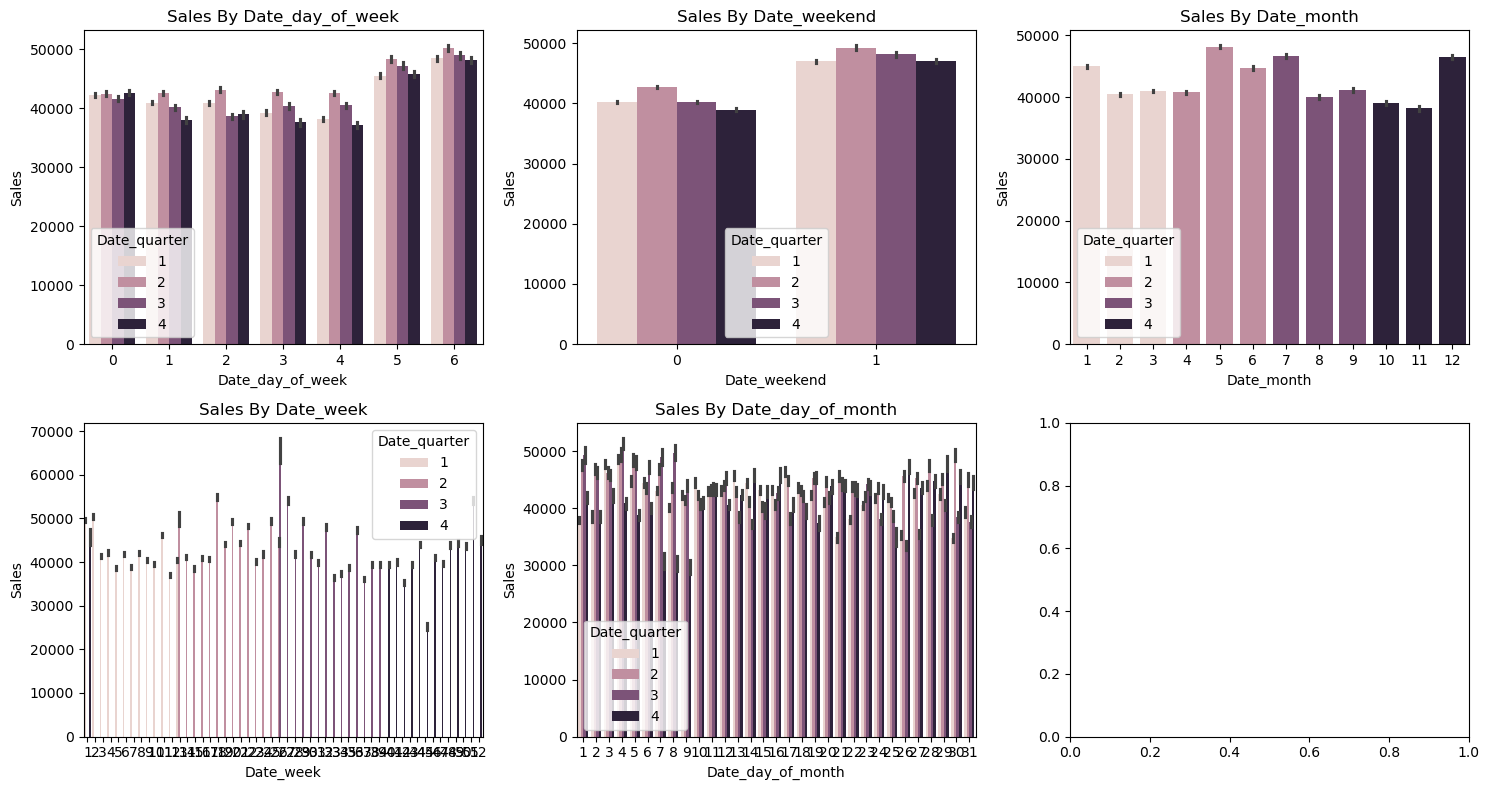

In [227]:
feats = ['Date_day_of_week',
 'Date_weekend',
 'Date_month',
 'Date_week',
        'Date_day_of_month']

fig, ax = plt.subplots(figsize=(15,8),
                      ncols=3,
                      nrows=2)

ax = ax.flatten() 

for i, feat in enumerate(feats): 
    
    sns.barplot(data=dtf_tab,
               x=feat,
               y='Sales',
               ax=ax[i],
                      hue='Date_quarter').set_title(f'Sales By {feat}')
    
plt.tight_layout()

In [228]:
month_dow = dtf_tab.groupby(['Date_quarter','Date_day_of_week'])[['Sales']].mean().reset_index()

import plotly.express as px 

px.line(month_dow,
       x='Date_day_of_week',
       y='Sales',
       color='Date_quarter',
       title='Weekly Seasonality By Month')

the main clear seasonal pattern we see is weekly, lets decompose the aggregated series using MSTL

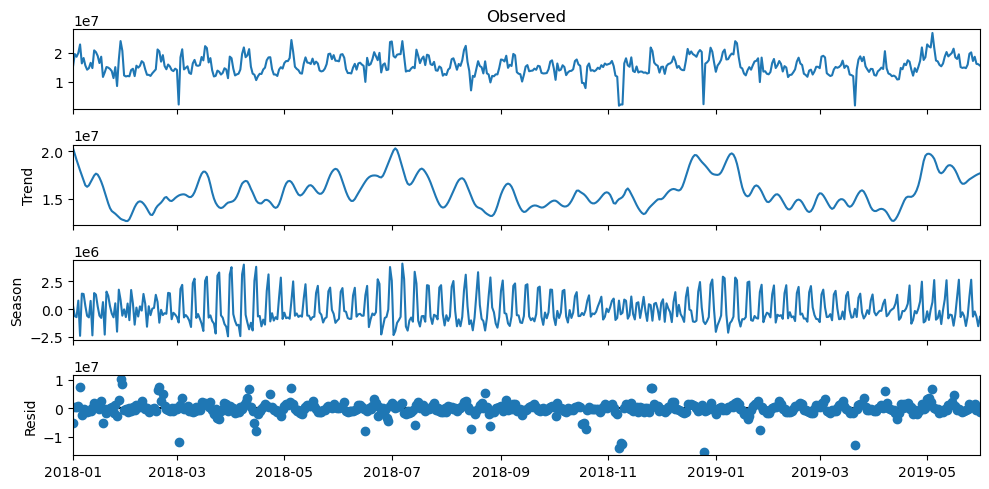

In [229]:
from statsmodels.tsa.seasonal import STL, MSTL 

tot_sales = train.resample('d',on='Date')[['Sales']].sum()

stl_res = STL(tot_sales,
             period=(7), # weekly seasonality 
             robust=True,
             seasonal_deg=0,
             seasonal=7).fit()

plt.rc('figure',figsize=(10,5))

stl_res.plot()

fig.tight_layout()

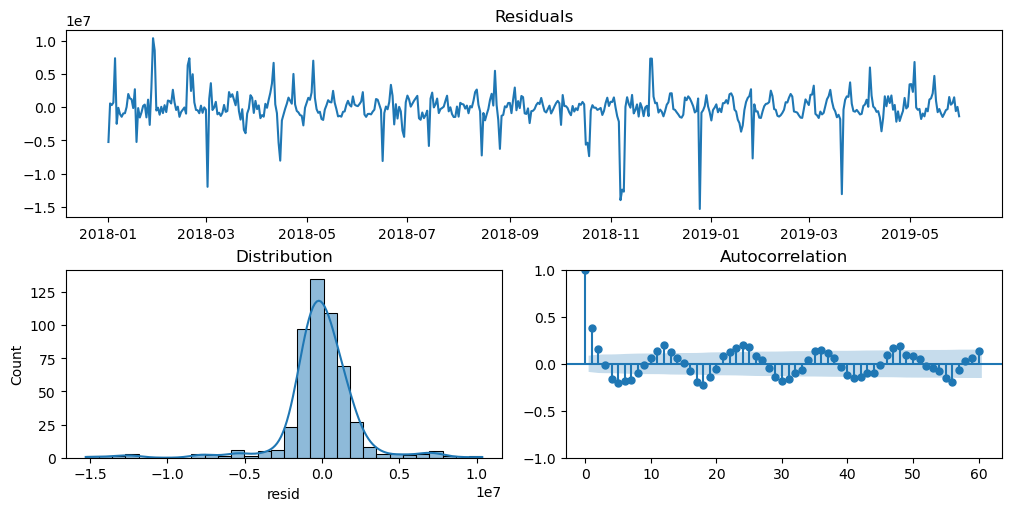

In [230]:
from skforecast.plot import plot_residuals 

plot_residuals(stl_res.resid)

plt.show()

We have autocorr in the residuals even after adjusting STL decomposition, lets examine the autocorrelation in the top level series... All we are doing right now is probing for large-scale seasonal patterns.

In [231]:
from statsmodels.tsa.stattools import adfuller, kpss


#h0: we have a unit root/timeseries is not stationary 
#hA: we don't have a unit root/stationary series 
adf_res = adfuller(tot_sales,regression='ct')
#h0: we don't have a unit root/stationary series  
#hA:we have a unit root/timeseries is not stationary due to trend... 
kpss_res = kpss(tot_sales,regression='ct')

print(f'ADF P_VALUE: {adf_res[1]:4f}')

print(f'KPSS P_VALUE: {kpss_res[1]:4f}') # it looks like we need to detrend/difference our series to ensure it is stationary due to KPSS test

ADF P_VALUE: 0.035541
KPSS P_VALUE: 0.091077


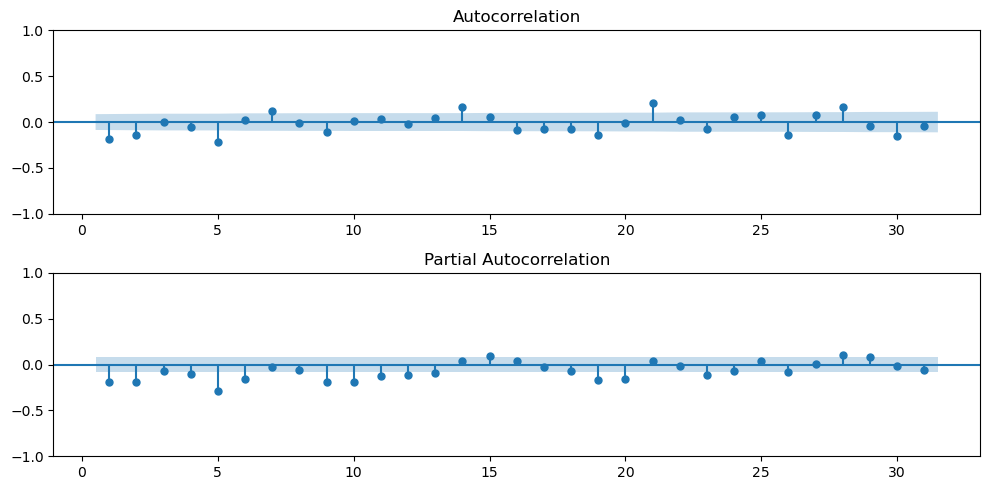

In [232]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, ax = plt.subplots(2)

diffd = tot_sales.diff().dropna()

plot_acf(diffd,zero=False,lags=31,ax=ax[0])

plot_pacf(diffd,zero=False,lags=31,ax=ax[1])

fig.tight_layout()

we see some seasonality remaining in the PACF and ACF after first difference. So some of these series follow an AR pattern.

The seasonality that is present is a bit hazy but we see small bumps every 7 lags.

Lets seasonally difference and inspect. We have strong seasonality at weekly level from STL

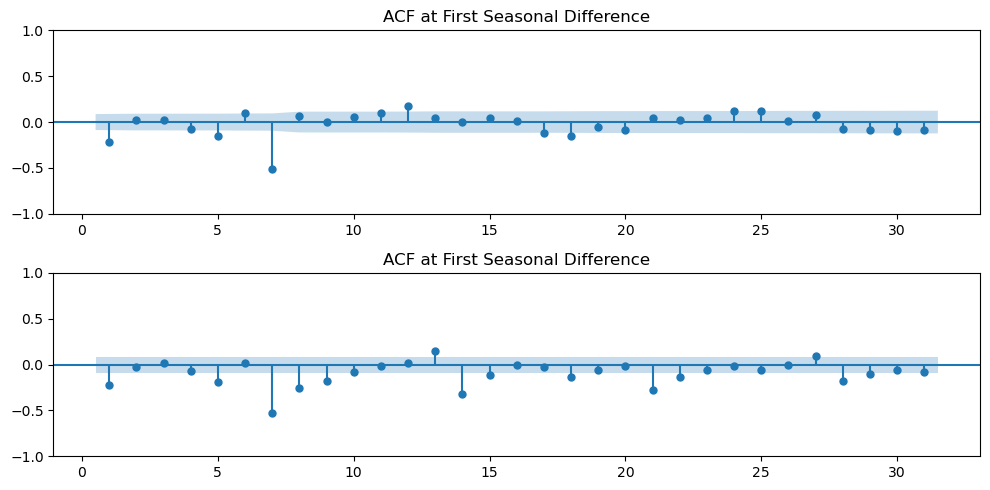

In [233]:
fig, ax = plt.subplots(2)

diffd = tot_sales.diff(7).diff().dropna()

plot_acf(diffd,zero=False,lags=31,ax=ax[0])

ax[0].set_title('ACF at First Seasonal Difference')

plot_pacf(diffd,zero=False,lags=31,ax=ax[1])

ax[1].set_title('ACF at First Seasonal Difference')

fig.tight_layout()

it looks like we have significant spikes at (p,q) of 2,2 and seasonal P,Q of 1,1 with a 7 day seasonality.

In [234]:
# leave out 3 months as val (we will make our backtest horizon 3x30 days)

train.rename(columns={'Store_id':'unique_id',
                     'Date':'ds',
                     'Sales':'y'},inplace=True)

val = train.groupby('unique_id').tail(90)

train = train.drop(val.index)

In [235]:
from tsfeatures import tsfeatures 

feat_based = tsfeatures(train,freq=365)

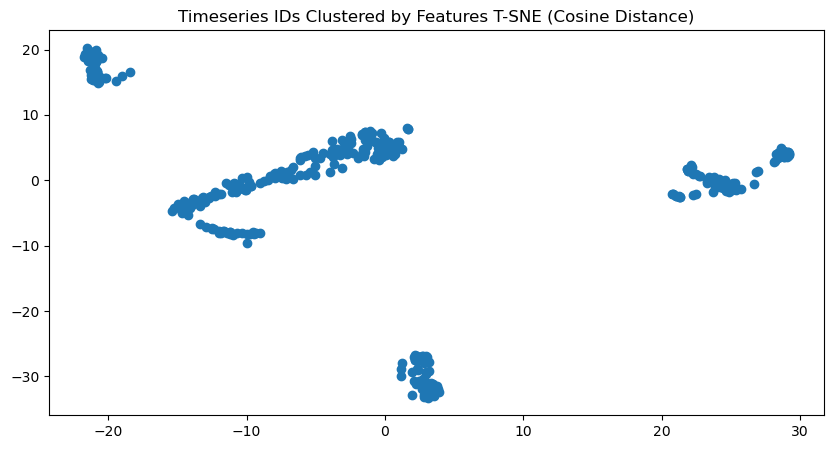

In [236]:
from sklearn.manifold import TSNE 

tsne = TSNE(n_components=2,
     init = 'pca',
     metric='cosine')

tsne_df = feat_based.dropna(axis=1).drop(columns=['unique_id'])

comps = tsne.fit_transform(tsne_df)

plt.title('Timeseries IDs Clustered by Features T-SNE (Cosine Distance)')
plt.scatter(comps[:,0],comps[:,1])
plt.show()

In [237]:
# lets try decomposing and clustering using KMEANS 
# 
# then examine these clusters, we will do this on a true train set.

from sklearn.decomposition import PCA, KernelPCA
#from sklearn.preprocessing import StandardScaler tsfeatures already scales these features 
from sklearn.cluster import KMeans 
from sklearn.pipeline import make_pipeline 

pca_pipe = KernelPCA(n_components=2, # pull 80% of the variance 
               random_state=42,
               kernel='cosine')

comps = pca_pipe.fit_transform(tsne_df)

km = KMeans(n_clusters=2)

km.fit(comps)

cluster_df = pd.DataFrame(comps,
             columns=['comp_1','comp_2']).assign(clusters = km.labels_)



<Axes: title={'center': 'Timeseries Clustered on Two PCA Components'}, xlabel='comp_1', ylabel='comp_2'>

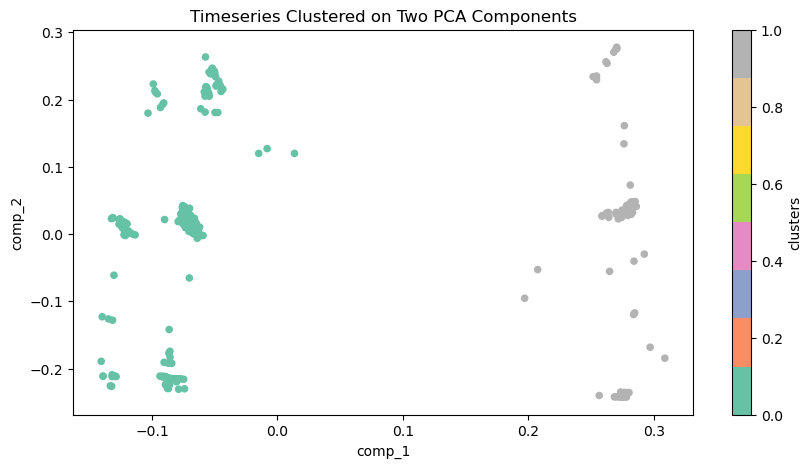

In [238]:
cluster_df.plot.scatter(x='comp_1',y='comp_2',c='clusters',
                        cmap='Set2',title='Timeseries Clustered on Two PCA Components')


# we see distinguishable difference when clustering based on cosine distance. 

* seasonal strength is the normalized seasonal component extracted from an MSTL composition (if i remember correctly.)

In [239]:
train.assign(orders_lag_1 = train['#Order'].shift().dropna(),
            sales_lag_1 = train['y'].shift().dropna()).corr(numeric_only=True) 

# we could possibly use lagged orders as a way to gauge sales, either way why not attempt to use it as a feature ??? (maybe in another notebook)

unique_id       Holiday    #Order         y  orders_lag_1  \
unique_id     1.000000e+00  7.495026e-16  0.027584  0.003008     -0.001686   
Holiday       7.495026e-16  1.000000e+00 -0.150252 -0.160981     -0.149845   
#Order        2.758379e-02 -1.502519e-01  1.000000  0.939415      0.154467   
y             3.007644e-03 -1.609805e-01  0.939415  1.000000      0.174073   
orders_lag_1 -1.685502e-03 -1.498452e-01  0.154467  0.174073      1.000000   
sales_lag_1  -1.447736e-03 -1.605069e-01  0.175746  0.239028      0.939415   

              sales_lag_1  
unique_id       -0.001448  
Holiday         -0.160507  
#Order           0.175746  
y                0.239028  
orders_lag_1     0.939415  
sales_lag_1      1.000000

In [240]:
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.linear_model import Ridge, Lasso
from utilsforecast.feature_engineering import trend, fourier, pipeline
from functools import partial

In [241]:
features = [#trend,
    partial(fourier,season_length=7,k=1),
           partial(fourier,season_length=28,k=1)]

horizon = 90 #90 day total horizon for features 

train_fourier, fut_exog = pipeline(features=features,
        df=train,
        freq='d',
        h=horizon)

# Feature Engineering

* Target encode the store numbers using native handling, remap discount columns (1,0)

In [242]:
train = train.assign(store_number = ('store_' + train.unique_id.astype(str)).astype('category'))

val = val.assign(store_number = ('store_' + val.unique_id.astype(str)).astype('category'))

train.Discount = train.Discount.map({'No':0,
                    'Yes':1})

val.Discount = val.Discount.map({'No':0,
                                 'Yes':1})

In [243]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd
from mlforecast.target_transforms import LocalMinMaxScaler,LocalStandardScaler,LocalRobustScaler
from feature_engine.encoding import OneHotEncoder

cat_features = ['Store_Type','Location_Type','Region_Code','store_number']

train[cat_features] = train[cat_features].astype('category')

models = {'catboost':CatBoostRegressor(cat_features=cat_features,
                                       random_state=42,
                                       iterations=250,
                                       subsample=.8),
                                       'lgb':LGBMRegressor(random_state=42,
                                                        subsample=.8,
                                                        n_estimators=250,
                                                        categorical_feature = cat_features),
                                       'RF':XGBRFRegressor(random_state=42,
                                                           parallel_tree=200,
                                                           objective='reg:squarederror',
                                                         n_estimators=250,
                                                         enable_categorical=True),

                                       'Linear':make_pipeline(OneHotEncoder(variables=cat_features,
                                                                            drop_last=True,
                                                                            ignore_format=True),
                                                                            Lasso(alpha=.01))}

def is_weekend(index): 
    
    return np.where(index.dayofweek.isin([5,6]),1,0)

mlf = MLForecast(models=models,
           freq='d',
           lags=[1,2,3,7],
           date_features=['day_of_week',is_weekend,'month','week','quarter'],
           num_threads=8,
           lag_transforms={1:[RollingMean(window_size=28,min_samples=1)],
                              
                              },
                              target_transforms=[LocalMinMaxScaler()])


#build statsforecast estimator for benchmarks 

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SimpleExponentialSmoothingOptimized,AutoETS

stats_models = [Naive(), 
                SeasonalNaive(season_length=7),
                SimpleExponentialSmoothingOptimized(),
                AutoETS(season_length=7)]

sf = StatsForecast(models=stats_models,
              freq='D',
              n_jobs=-1)

stat_df = train[['unique_id','ds','y']]


sfcv = sf.cross_validation(df=stat_df,
                    h=30,
                    n_windows=4,
                    step_size=90)

In [244]:
# cross validate our model on the train set and gauge performance on the validation set 

train_ = train.drop(columns=["ID",'#Order'],axis=1)

val_ = val.drop(columns = ["ID",'#Order'],axis=1)

In [245]:
cv_results = mlf.cross_validation(df=train_,
                     n_windows=4, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=120,
                     static_features=cat_features,
                     )

Learning rate set to 0.183466
0:	learn: 0.2030725	total: 10.5ms	remaining: 2.61s
1:	learn: 0.1813552	total: 18.3ms	remaining: 2.27s
2:	learn: 0.1669549	total: 24.3ms	remaining: 2s
3:	learn: 0.1543155	total: 29.8ms	remaining: 1.83s
4:	learn: 0.1438478	total: 33.8ms	remaining: 1.66s
5:	learn: 0.1358839	total: 38.3ms	remaining: 1.56s
6:	learn: 0.1301040	total: 43ms	remaining: 1.49s
7:	learn: 0.1259682	total: 48.4ms	remaining: 1.46s
8:	learn: 0.1225724	total: 51.7ms	remaining: 1.39s
9:	learn: 0.1200031	total: 58.6ms	remaining: 1.41s
10:	learn: 0.1173558	total: 63.7ms	remaining: 1.38s
11:	learn: 0.1162030	total: 67.6ms	remaining: 1.34s
12:	learn: 0.1151279	total: 70.9ms	remaining: 1.29s
13:	learn: 0.1129226	total: 75ms	remaining: 1.26s
14:	learn: 0.1117565	total: 78ms	remaining: 1.22s
15:	learn: 0.1110355	total: 81.6ms	remaining: 1.19s
16:	learn: 0.1097700	total: 86.7ms	remaining: 1.19s
17:	learn: 0.1085498	total: 91.6ms	remaining: 1.18s
18:	learn: 0.1081534	total: 94.7ms	remaining: 1.15s
1

In [246]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

cv_melt = (pd.concat([cv_results,
                     sfcv.drop(columns=['y','ds','cutoff']).reset_index(drop=True)],axis=1)

    .melt(id_vars=['unique_id','ds','cutoff','y'],
          
                var_name='model',
                
                value_name='y_pred'))

cv_melt.y_pred = np.clip(cv_melt.y_pred,a_min=0,a_max=None)

cv_melt.head()

unique_id         ds     cutoff        y     model        y_pred
0          1 2018-02-06 2018-02-05  31098.0  catboost  32458.440447
1          1 2018-02-07 2018-02-05  33282.0  catboost  42612.895638
2          1 2018-02-08 2018-02-05  44922.0  catboost  36101.906663
3          1 2018-02-09 2018-02-05  38169.0  catboost  36835.621508
4          1 2018-02-10 2018-02-05  38169.0  catboost  36648.564202

{'AutoETS': 18152.568, 'Linear': 9165.7955, 'Naive': 19319.0387, 'RF': 6934.4401, 'SESOpt': 17666.3022, 'SeasonalNaive': 18398.5098, 'catboost': 7485.9298, 'lgb': 7080.9364}


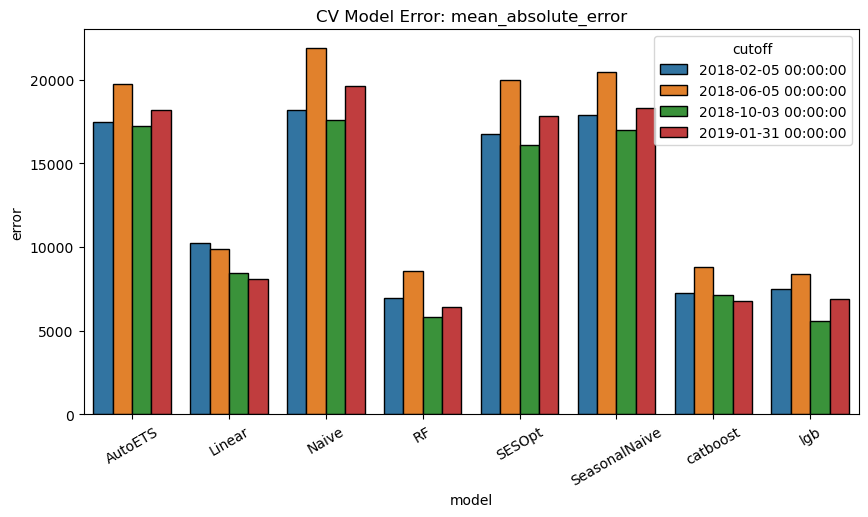

{'AutoETS': 0.3222, 'Linear': 0.1226, 'Naive': 0.3584, 'RF': 0.075, 'SESOpt': 0.3131, 'SeasonalNaive': 0.3509, 'catboost': 0.0879, 'lgb': 0.0828}


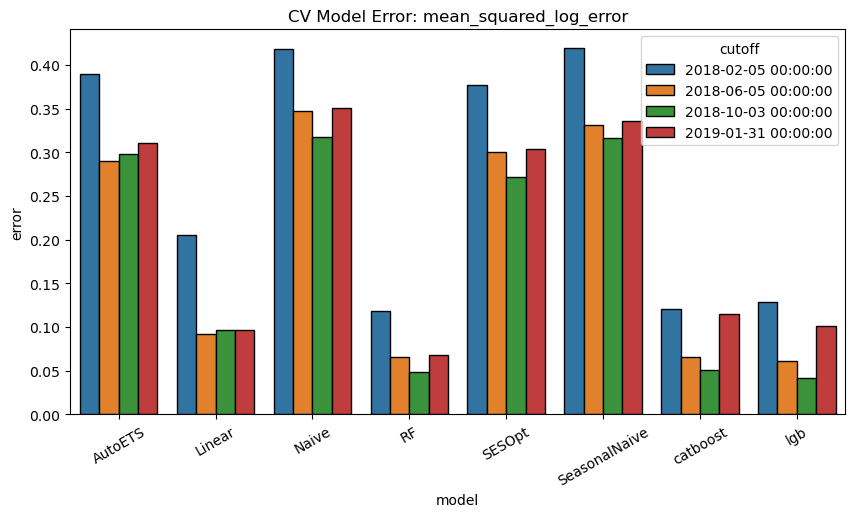

{'AutoETS': 0.435, 'Linear': 0.2195, 'Naive': 0.4623, 'RF': 0.1653, 'SESOpt': 0.4228, 'SeasonalNaive': 0.4405, 'catboost': 0.1789, 'lgb': 0.1689}


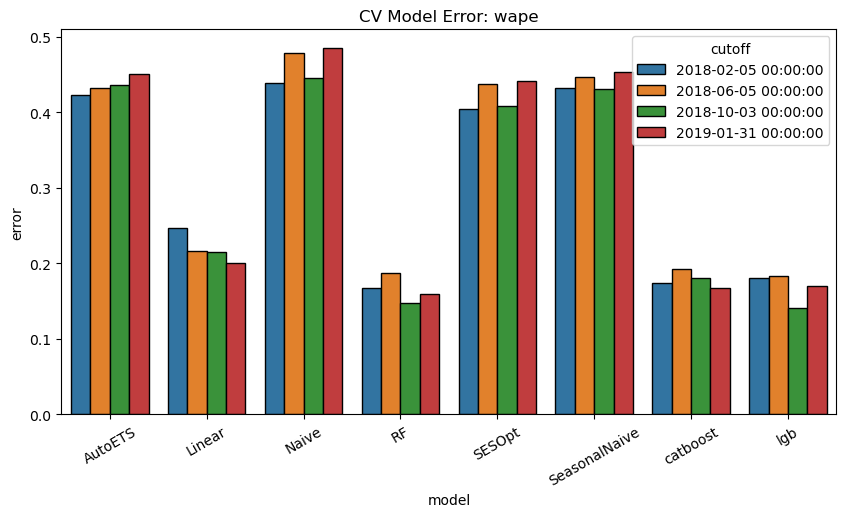

In [247]:
def wape(y_true,y_pred): 

    sum_errors = sum(abs(y_pred-y_true))

    return sum_errors / np.sum(y_true)

metrics = [mean_absolute_error,mean_squared_log_error,wape]

pooled_res = {}

for metric in metrics: 

    cv_error = cv_melt.groupby(['model','cutoff'],observed=True)\
        .apply(lambda group: metric(group['y'],
                                                group['y_pred'])).reset_index(name='error')
    
    sns.barplot(data=cv_error,
                x='model',
                y='error',
                hue='cutoff',
                edgecolor='black',
                errorbar=('ci',False)
                ).set_title(f'CV Model Error: {metric.__name__}')
    
    pooled_errors = cv_error.groupby("model").mean(numeric_only=True).error.to_dict()

    pooled_errors = {key:round(value,4) for key, value in pooled_errors.items()}

    pooled_res[metric.__name__] = pooled_errors

    print(pooled_errors)
    
    plt.xticks(rotation=30)
    
    plt.show()

In [248]:
model_choice = cv_melt.query('model in ("catboost","RF","lgb")')

model_choice['resid'] = model_choice['y_pred'] - model_choice['y']

px.box(model_choice,
       x='cutoff',
       y='resid',
       color='model',
       title='Residuals by Model Across 3 Folds',
       labels={'resid':'Residuals',
               'cutoff':'CV-Fold',
               'model':'Model'})

In [249]:
wape_dist = model_choice.groupby(['model','unique_id'],observed=True)\
        .apply(lambda group: wape(group['y'],
                                    group['y_pred'])).reset_index(name='error')

px.box(wape_dist,
       x='model',
       y='error',
       color='model',
       title='WAPE by Model Across 3 Folds',
       labels={'resid':'Residuals',
               'cutoff':'CV-Fold',
               'model':'Model'})

In [250]:
def forecast_bias(y_true:np.ndarray, y_pred:np.ndarray):
    '''returns forecast bias as a percentage of total sales'''
    numerator = np.sum(y_pred - y_true)

    denom = np.sum(y_true)

    return (numerator / denom) * 100 

bias_dist = model_choice.groupby(['model','unique_id'],observed=True)\
        .apply(lambda group: forecast_bias(group['y'],
                                    group['y_pred'])).reset_index(name='error')

px.box(bias_dist,
       x='error',
       color='model',
       title='Forecast Bias by Model Across 3 Folds',
       labels={'resid':'Residuals',
               'cutoff':'CV-Fold',
               'model':'Model'})

* it looks like lgb and catboost have lower error and lower bias, let's now tune these models to ensure best fit and rescore on the validation set.

In [251]:
from mlforecast.auto import AutoMLForecast, AutoModel
import optuna 

def lgb_params(trial: optuna.Trial): 

    return {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
       # "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
       # 'reg_lambda':trial.suggest_uniform('reg_lambda',0,.9)
        # Add other parameters as needed
    }

def catboost_config(trial: optuna.Trial):
    return {
        "iterations": trial.suggest_int("iterations", 100, 500),
       # "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1),
       # "depth": trial.suggest_int("depth", 4, 10),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1),
       #'reg_lambda':trial.suggest_uniform('reg_lambda',0,1),
         # "l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1, 10),  # Increased regularization
        # Add other parameters as needed
    }

  #utilize optuna function to select all exog features in the model
def fit_config(trial: optuna.Trial):

    return {'static_features': cat_features}

def init_config(trial: optuna.Trial): 
    
    lag_feats = [1,2,3,7]
    
    lag_transforms = {
        1:[RollingMean(window_size=28,min_samples=1)]}
    
    target_transforms = [LocalMinMaxScaler()]
    
    return {'lags':lag_feats,
            'lag_transforms':lag_transforms,
            'target_transforms':target_transforms,
                   'date_features':['day_of_week',is_weekend,'month','week','quarter']}

tune_cat = AutoModel(model=CatBoostRegressor(cat_features=cat_features,
                                             verbose=False,
                                             eval_metric="MSLE"),
                     config=catboost_config)

tune_lgb = AutoModel(
    model= LGBMRegressor(categorical_feature = cat_features,verbosity = -1),
    config=lgb_params,
)

auto_mlf = AutoMLForecast(
    models={'my_lgb': tune_lgb,
            'my_catboost':tune_cat},
    freq='d',
    season_length=365,
    fit_config=fit_config,
    init_config=init_config
)

auto_mlf.fit(
    train_,
    n_windows=4,
    h=90,
    num_samples=10 # 30 trials over 3 windows of the data 
)

tot = pd.concat([train_,val_])

[I 2024-08-13 10:22:07,367] A new study created in memory with name: no-name-bf24cb6f-9f93-4846-998d-bc5b3568163a
[I 2024-08-13 10:22:12,078] Trial 0 finished with value: 0.13012169344652327 and parameters: {'n_estimators': 320, 'num_leaves': 77, 'subsample': 0.8411053504286575}. Best is trial 0 with value: 0.13012169344652327.
[I 2024-08-13 10:22:16,193] Trial 1 finished with value: 0.12995166191308244 and parameters: {'n_estimators': 318, 'num_leaves': 54, 'subsample': 0.8583576452266624}. Best is trial 1 with value: 0.12995166191308244.
[I 2024-08-13 10:22:20,877] Trial 2 finished with value: 0.1306614586249019 and parameters: {'n_estimators': 275, 'num_leaves': 92, 'subsample': 0.9854651042004117}. Best is trial 1 with value: 0.12995166191308244.
[I 2024-08-13 10:22:25,020] Trial 3 finished with value: 0.13024380703753788 and parameters: {'n_estimators': 253, 'num_leaves': 84, 'subsample': 0.8115579679011617}. Best is trial 1 with value: 0.12995166191308244.
[I 2024-08-13 10:22:30,

In [252]:
val_[cat_features] = val_[cat_features].astype('category')

#predict ahead 90 days and score against validation set (unseen data)
preds = auto_mlf.predict(h=90,
                         X_df=val_.drop(columns=cat_features))

In [253]:
lgb_params = auto_mlf.results_['my_lgb'].best_params

catboost_params = auto_mlf.results_['my_catboost'].best_params

#set new parameters in model
mlf.models['catboost'].set_params(**catboost_params)
mlf.models['lgb'].set_params(**lgb_params)

LGBMRegressor(categorical_feature=['Store_Type', 'Location_Type', 'Region_Code',
                                   'store_number'],
              n_estimators=134, num_leaves=21, random_state=42,
              subsample=0.9330479382191752)

* rerun the month ahead cross validation with new parameters and examine performance, on val set.

In [254]:
tot[cat_features] = tot[cat_features].astype('category')

cv_new = mlf.cross_validation(df=tot,
                      n_windows=3, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=30,
                     static_features=cat_features,
                     )

Learning rate set to 0.204766
0:	learn: 0.1384194	total: 38ms	remaining: 13.9s
1:	learn: 0.1273353	total: 65.8ms	remaining: 12s
2:	learn: 0.1192960	total: 94.8ms	remaining: 11.5s
3:	learn: 0.1135588	total: 130ms	remaining: 11.8s
4:	learn: 0.1092600	total: 158ms	remaining: 11.4s
5:	learn: 0.1061806	total: 191ms	remaining: 11.5s
6:	learn: 0.1036435	total: 226ms	remaining: 11.6s
7:	learn: 0.1018755	total: 254ms	remaining: 11.4s
8:	learn: 0.1002344	total: 285ms	remaining: 11.3s
9:	learn: 0.0991420	total: 308ms	remaining: 11s
10:	learn: 0.0974697	total: 339ms	remaining: 11s
11:	learn: 0.0963207	total: 366ms	remaining: 10.8s
12:	learn: 0.0947806	total: 400ms	remaining: 10.9s
13:	learn: 0.0941472	total: 429ms	remaining: 10.8s
14:	learn: 0.0934359	total: 463ms	remaining: 10.9s
15:	learn: 0.0928332	total: 504ms	remaining: 11.1s
16:	learn: 0.0920917	total: 539ms	remaining: 11.1s
17:	learn: 0.0915661	total: 574ms	remaining: 11.1s
18:	learn: 0.0911173	total: 608ms	remaining: 11.1s
19:	learn: 0.090

In [255]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import * 

def eval_model(df): 

        #melt dataframe to long format in order to compute error per model-cutoff
        df = df.melt(id_vars=['ds','unique_id','cutoff','y'],
            value_name='y_pred',
            var_name='model')
        
        df.y_pred = np.clip(df.y_pred,a_min=0,a_max=None)
        
        mae_val = df.groupby(['model','cutoff']).apply(lambda group: mean_absolute_error(group['y'],group['y_pred']))

        msle_val = df.groupby(['model','cutoff']).apply(lambda group: mean_squared_log_error(group['y'],group['y_pred']))

        wape_val = df.groupby(['model','cutoff']).apply(lambda group: wape(group['y'],group['y_pred']))

        bias_val = df.groupby(['model','cutoff']).apply(lambda group: forecast_bias(group['y'],group['y_pred']))

        error_eval = pd.concat([mae_val,msle_val,
                          wape_val,bias_val],axis=1)
        
        error_eval.columns = ['mean_absolute_error','mean_squared_log_error','wape','forecast_bias']
        
        return error_eval

val_metrics = eval_model(cv_new)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'catboost'),
  Text(1, 0, 'lgb'),
  Text(2, 0, 'tuned_validation_catboost'),
  Text(3, 0, 'tuned_validation_lgb')])

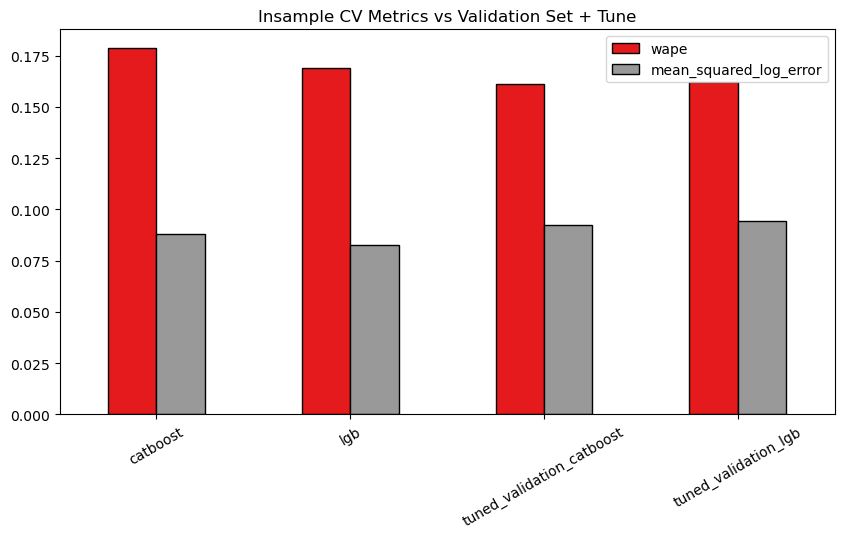

In [256]:
cv_metrics = pd.DataFrame(pooled_res)

cv_metrics.index.name = 'model'

val_metrics_ = val_metrics.groupby('model').mean(numeric_only=True)

val_metrics_.index = ['tuned_validation_' + x for x in val_metrics_.index]


comp = pd.concat([cv_metrics.loc['catboost':],
          val_metrics_.loc['tuned_validation_catboost':]]).dropna(axis=1)


comp.plot.bar(title='Insample CV Metrics vs Validation Set + Tune',
               edgecolor='black',
               y=['wape','mean_squared_log_error'],
               cmap='Set1')

plt.xticks(rotation=30)

In [257]:
# now lets try comparing these metrics to the "cluster" approach

cluster_map = cluster_df[['clusters']]\
    .set_index(feat_based.unique_id).to_dict()['clusters']


train_ = train_.assign(clusters = train_.unique_id.map(cluster_map))

val_ = val_.assign(clusters = val_.unique_id.map(cluster_map))

train_.clusters.value_counts(normalize=True) # it looks like only 22% of our series are cluster 1 

train_.groupby('clusters').y.describe()

count          mean           std  min      25%      50%  \
clusters                                                                
0         120558.0  43034.418002  18178.879713  0.0  30843.0  40200.0   
1          34932.0  41114.188435  17496.433698  0.0  29418.0  37848.0   

               75%       max  
clusters                      
0         52316.25  219984.0  
1         49401.75  154113.0

In [258]:
cv_results_cluster = mlf.cross_validation(df=train_,
                     n_windows=4, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=120,
                     static_features=cat_features,
                     )

Learning rate set to 0.134279
0:	learn: 0.2088156	total: 8.81ms	remaining: 3.22s
1:	learn: 0.1920349	total: 14.7ms	remaining: 2.67s
2:	learn: 0.1777862	total: 19.7ms	remaining: 2.39s
3:	learn: 0.1665698	total: 27.5ms	remaining: 2.49s
4:	learn: 0.1570477	total: 32.2ms	remaining: 2.33s
5:	learn: 0.1497659	total: 38ms	remaining: 2.29s
6:	learn: 0.1432032	total: 44.2ms	remaining: 2.27s
7:	learn: 0.1378314	total: 50.8ms	remaining: 2.28s
8:	learn: 0.1330736	total: 56.1ms	remaining: 2.23s
9:	learn: 0.1291298	total: 61.6ms	remaining: 2.2s
10:	learn: 0.1257752	total: 67ms	remaining: 2.17s
11:	learn: 0.1228923	total: 72.3ms	remaining: 2.14s
12:	learn: 0.1211468	total: 76.9ms	remaining: 2.09s
13:	learn: 0.1192204	total: 82ms	remaining: 2.07s
14:	learn: 0.1176367	total: 86.1ms	remaining: 2.02s
15:	learn: 0.1162797	total: 90.3ms	remaining: 1.98s
16:	learn: 0.1150576	total: 94.1ms	remaining: 1.94s
17:	learn: 0.1141532	total: 98.4ms	remaining: 1.91s
18:	learn: 0.1128148	total: 102ms	remaining: 1.86s


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'catboost'),
  Text(1, 0, 'lgb'),
  Text(2, 0, 'tuned_validation_catboost'),
  Text(3, 0, 'tuned_validation_lgb'),
  Text(4, 0, 'cluster_feature_catboost'),
  Text(5, 0, 'cluster_feature_lgb')])

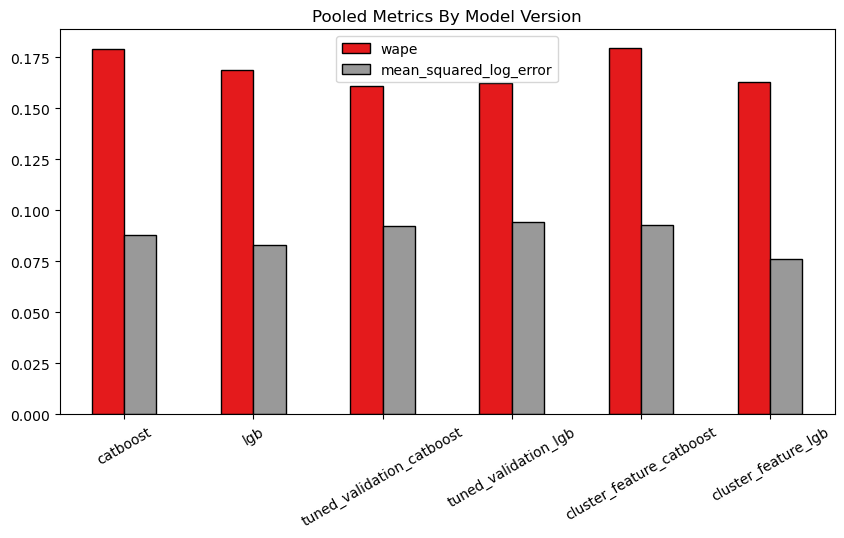

In [259]:
cluster_pooled = eval_model(cv_results_cluster).loc['catboost':]\
        .reset_index()\
                .groupby('model').mean(numeric_only=True)

cluster_pooled.index = ['cluster_feature_' + x for x in cluster_pooled.index]

comp_new = pd.concat([comp,cluster_pooled]).dropna(axis=1)


comp_new.plot(kind='bar',
                                                     y=['wape','mean_squared_log_error'],
                                                     edgecolor='black',
                                                     cmap='Set1',
                                                     title='Pooled Metrics By Model Version')

plt.xticks(rotation=30)

In [260]:
cluster_zero = mlf.cross_validation(df=train_.query('clusters == 0'),
                     n_windows=4, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=120,
                     static_features=cat_features,
                     )


cluster_one = mlf.cross_validation(df=train_.query('clusters == 1'),
                     n_windows=4, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=120,
                     static_features=[],
                     )

Learning rate set to 0.128987
0:	learn: 0.2135162	total: 9.15ms	remaining: 3.35s
1:	learn: 0.1963642	total: 15.4ms	remaining: 2.81s
2:	learn: 0.1816051	total: 19.7ms	remaining: 2.39s
3:	learn: 0.1689989	total: 24.7ms	remaining: 2.24s
4:	learn: 0.1585754	total: 28.7ms	remaining: 2.07s
5:	learn: 0.1502971	total: 32.6ms	remaining: 1.96s
6:	learn: 0.1434404	total: 37.1ms	remaining: 1.91s
7:	learn: 0.1378950	total: 40.8ms	remaining: 1.83s
8:	learn: 0.1331345	total: 44.3ms	remaining: 1.76s
9:	learn: 0.1292043	total: 47.4ms	remaining: 1.69s
10:	learn: 0.1251092	total: 51.3ms	remaining: 1.66s
11:	learn: 0.1224102	total: 54.8ms	remaining: 1.62s
12:	learn: 0.1205132	total: 57.9ms	remaining: 1.57s
13:	learn: 0.1186031	total: 60.8ms	remaining: 1.53s
14:	learn: 0.1169692	total: 63.9ms	remaining: 1.5s
15:	learn: 0.1152082	total: 67.5ms	remaining: 1.48s
16:	learn: 0.1138520	total: 71.2ms	remaining: 1.47s
17:	learn: 0.1130627	total: 74.1ms	remaining: 1.44s
18:	learn: 0.1121472	total: 77ms	remaining: 1

In [261]:
partition_eval = pd.concat([cluster_zero,cluster_one])

part_eval = eval_model(partition_eval).groupby('model').mean(numeric_only=True).loc['catboost':]

part_eval.index = ['partition_cluster_' + x for x in part_eval.index]

pd.concat([part_eval,
           comp_new]).dropna(axis=1).style.highlight_min(color='lightgreen') # it looks like our clustering didn't really help us improve model performance

In [262]:
train_set = mlf.preprocess(train_)

y_train = train_set[['y']]

X_train = train_set.drop(['y','ds'],axis=1)

val_set = mlf.preprocess(val_)

y_val = val_set[['y']]

X_val = val_set.drop(['y','ds'],axis=1)

In [275]:
# lets compute permutation importances 

from sklearn.inspection import permutation_importance

cbr = CatBoostRegressor(**catboost_params,
                  cat_features=cat_features,
                  random_state=42)

cbr.fit(X_train,y_train)

lgb = LGBMRegressor(**lgb_params,
                  categorical_feature=cat_features,
                  random_state=42)

lgb.fit(X_train,y_train)

Learning rate set to 0.204766
0:	learn: 0.1384930	total: 103ms	remaining: 37.7s
1:	learn: 0.1274672	total: 137ms	remaining: 25.1s
2:	learn: 0.1194611	total: 173ms	remaining: 21s
3:	learn: 0.1136375	total: 210ms	remaining: 19s
4:	learn: 0.1095466	total: 248ms	remaining: 18s
5:	learn: 0.1063219	total: 278ms	remaining: 16.7s
6:	learn: 0.1039909	total: 324ms	remaining: 16.7s
7:	learn: 0.1016891	total: 365ms	remaining: 16.4s
8:	learn: 0.1000499	total: 420ms	remaining: 16.7s
9:	learn: 0.0987519	total: 467ms	remaining: 16.7s
10:	learn: 0.0977700	total: 510ms	remaining: 16.5s
11:	learn: 0.0964634	total: 547ms	remaining: 16.2s
12:	learn: 0.0956685	total: 569ms	remaining: 15.5s
13:	learn: 0.0949391	total: 592ms	remaining: 14.9s
14:	learn: 0.0944077	total: 612ms	remaining: 14.4s
15:	learn: 0.0939132	total: 647ms	remaining: 14.2s
16:	learn: 0.0934884	total: 676ms	remaining: 13.9s
17:	learn: 0.0931621	total: 715ms	remaining: 13.9s
18:	learn: 0.0928402	total: 753ms	remaining: 13.8s
19:	learn: 0.0922

LGBMRegressor(categorical_feature=['Store_Type', 'Location_Type', 'Region_Code',
                                   'store_number'],
              n_estimators=134, num_leaves=21, random_state=42,
              subsample=0.9330479382191752)

In [276]:
#Calculate permutation importances

result_catboost = permutation_importance(cbr,
                                 X_train,
                                   y_train,
                                 n_repeats=20,
                                   random_state=42,
                                     scoring='neg_root_mean_squared_error')


result_lgb = permutation_importance(lgb,
                                 X_train,
                                   y_train,
                                 n_repeats=20,
                                   random_state=42,
                                     scoring='neg_root_mean_squared_error')

In [297]:
catboost_perm = pd.Series(dict(zip(X_val.columns,result_catboost.importances_mean))).sort_values()
lgbm_perm = pd.Series(dict(zip(X_val.columns,result_lgb.importances_mean))).sort_values()

perm_imps = pd.concat([catboost_perm,lgbm_perm],axis=1)\
.rename(columns={0:'catboost',
1:'lgb'})

<Axes: title={'center': 'Permutation Importances of Feature-set (Catboost)'}, xlabel='Permutation Importance', ylabel='Features'>

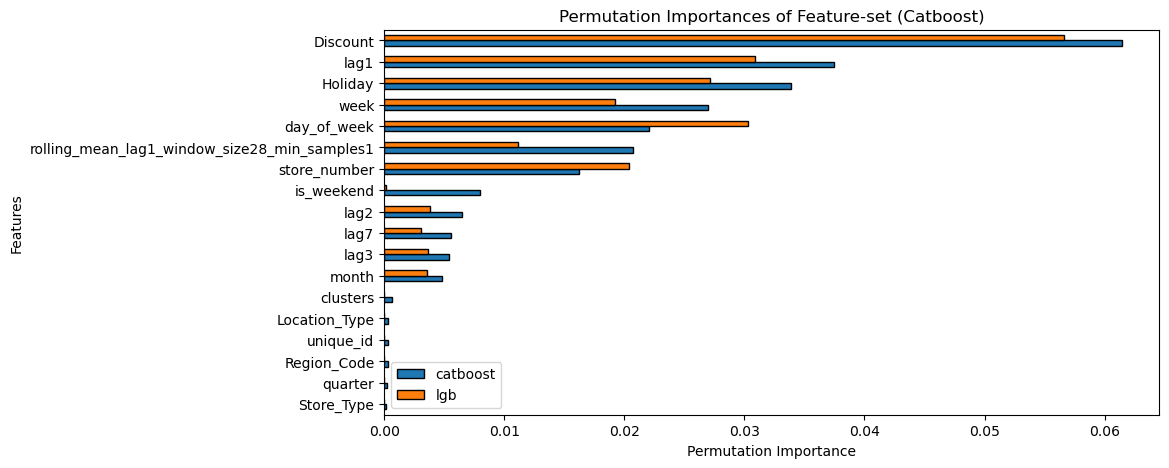

In [299]:
perm_imps.plot.barh(title='Permutation Importances of Feature-set (Catboost)',
               ylabel='Features',
               xlabel='Permutation Importance',
               edgecolor='black')

* it looks like our lgbm model with clustering did the best with a (MSLE * 1000) target metric of 84 ! 

* I can't find the leaderboard but I suspect this is a good score.

In [474]:
import matplotlib.pyplot as plt

def plot_cv(df, df_cv, uid,models, last_n=24 * 14):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()

    fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(10, 6), gridspec_kw=dict(hspace=0.8),sharex=True)
    for cutoff, axi in zip(cutoffs, ax.flat):
        df.query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds')\
            .plot(ax=axi, title='store_' + str(uid) +'_forecast', y=models)
        axi.legend(bbox_to_anchor=(1,1))

In [331]:
#now lets use cross validation to simulate the forecast across 6 months 

simulated_forecast = mlf.cross_validation(df=train_,
                     n_windows=6, # cross validate one month ahead across 6 folds
                     h=30,
                     step_size=30,
                     static_features=cat_features,
                     )

Learning rate set to 0.187385
0:	learn: 0.1424042	total: 36.1ms	remaining: 13.2s
1:	learn: 0.1317303	total: 57.5ms	remaining: 10.5s
2:	learn: 0.1235603	total: 78.9ms	remaining: 9.57s
3:	learn: 0.1177610	total: 99.4ms	remaining: 9.02s
4:	learn: 0.1134069	total: 115ms	remaining: 8.31s
5:	learn: 0.1097515	total: 132ms	remaining: 7.92s
6:	learn: 0.1071560	total: 156ms	remaining: 8.04s
7:	learn: 0.1048654	total: 177ms	remaining: 7.94s
8:	learn: 0.1030153	total: 199ms	remaining: 7.93s
9:	learn: 0.1016153	total: 225ms	remaining: 8.02s
10:	learn: 0.1004050	total: 251ms	remaining: 8.11s
11:	learn: 0.0991987	total: 272ms	remaining: 8.04s
12:	learn: 0.0984798	total: 294ms	remaining: 8.01s
13:	learn: 0.0977370	total: 317ms	remaining: 7.99s
14:	learn: 0.0971252	total: 332ms	remaining: 7.79s
15:	learn: 0.0964772	total: 347ms	remaining: 7.62s
16:	learn: 0.0960707	total: 360ms	remaining: 7.42s
17:	learn: 0.0955419	total: 376ms	remaining: 7.29s
18:	learn: 0.0945827	total: 392ms	remaining: 7.18s
19:	lea

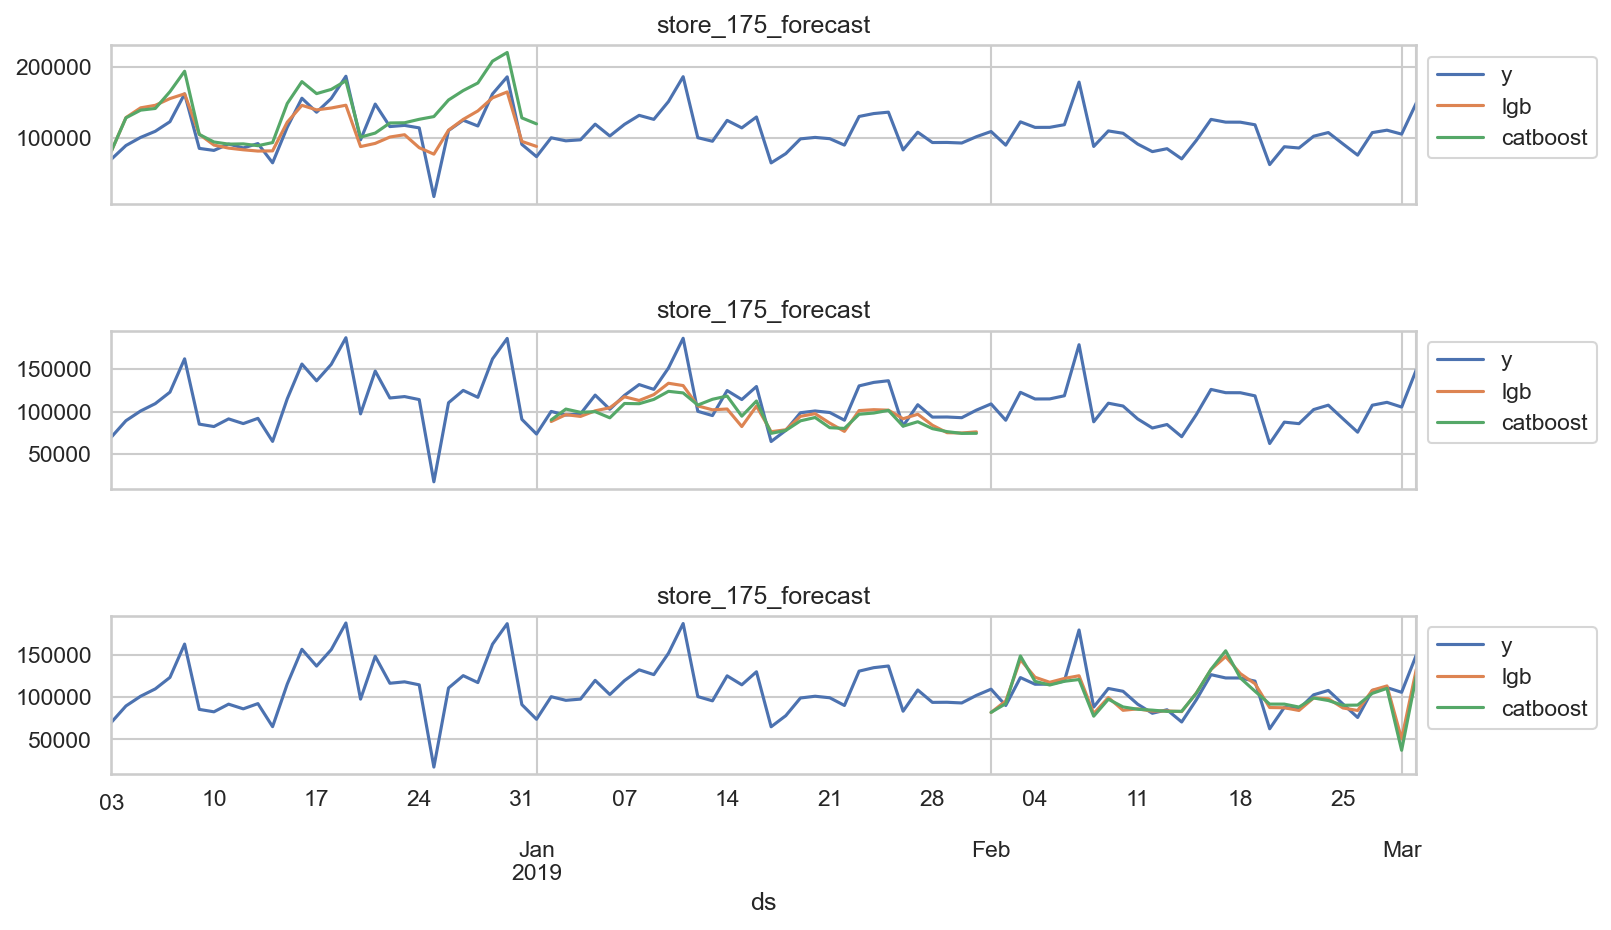

In [475]:
from utilsforecast.plotting import plot_series 

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

# Set the theme for the plot
sns.set_theme(style="whitegrid")

cutoffs = simulated_forecast.cutoff.unique()[-3:]

rand_store = simulated_forecast.unique_id.sample(n=1).values[0]

plot_cv(df=simulated_forecast.loc[simulated_forecast.cutoff.isin(cutoffs)],
        df_cv=simulated_forecast.loc[simulated_forecast.cutoff.isin(cutoffs)],
        uid=rand_store,
        models=['lgb','catboost'],
        last_n=30*3)

* although we are forecasting what seems to be revenue lets attempt to compute some supply chain KPIs on the simulated forecast.

In [439]:
def avg_instock(y_true,y_pred):
    '''fill rate as the average instock'''
    fill_rate = np.minimum(y_true,y_pred) / y_true

    return np.mean(fill_rate) * 100

def low_stock_events(y_true, y_pred, T, carryover_periods):
    """
    Count low stock events as any week where the stock level is less than the target T.
    
    Parameters:
    - y_true: Actual demand
    - y_pred: Forecasted demand
    - T: Stock target threshold (e.g., 0.80 for 80%)
    - carryover_periods: Number of periods of carryover stock"""
    
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Initialize an array to keep track of stock levels
    stock_levels = np.zeros(len(y_true))
    
    # Compute the stock levels considering carryover
    for i in range(len(y_true)):
        # Calculate carryover for the current week
        carryover = sum(y_pred[max(0, i - carryover_periods + 1):i])
        # Calculate actual stock level
        stock_levels[i] = carryover + y_pred[i]
    
    # Calculate the fill rate as the proportion of actual demand met by the stock level
    fill_rate = np.minimum(stock_levels, y_true) / y_true
    
    # Count the number of low stock events where fill rate is less than the target T
    low_stock_events_count = np.sum(fill_rate < T)
    
    return low_stock_events_count

In [482]:
sim = simulated_forecast.melt(id_vars=['ds','unique_id','cutoff','y'],
            value_name='y_pred',
            var_name='model')

#resample the forecast to weekly level 
sim = sim.groupby(['unique_id','cutoff','model']).resample('w',on='ds').sum().reset_index()

#make mapper dict for cv names 
cv_folds = dict(zip(sim.cutoff.unique(),[f'cv_fold_{i+1}' for i in range(0,len(sim.cutoff.unique()))]))

#map cleaned up names to the cv_fold names 
sim.cutoff = sim.cutoff.map(cv_folds)

#calulcate number of events below specified service level, given we rollover excess inventory for n weeks past 
lo_stock = sim.groupby(['model','cutoff'])\
    .apply(lambda group: low_stock_events(group['y'],group['y_pred'],T=.95,carryover_periods=2))

#compute average service level as a % 
service_lvl = sim.groupby(['model','cutoff'])\
    .apply(lambda group: avg_instock(group['y'],group['y_pred']))

Text(0.5, 1.0, 'Low Stock Events (Days < 80% Service Level) by Model')

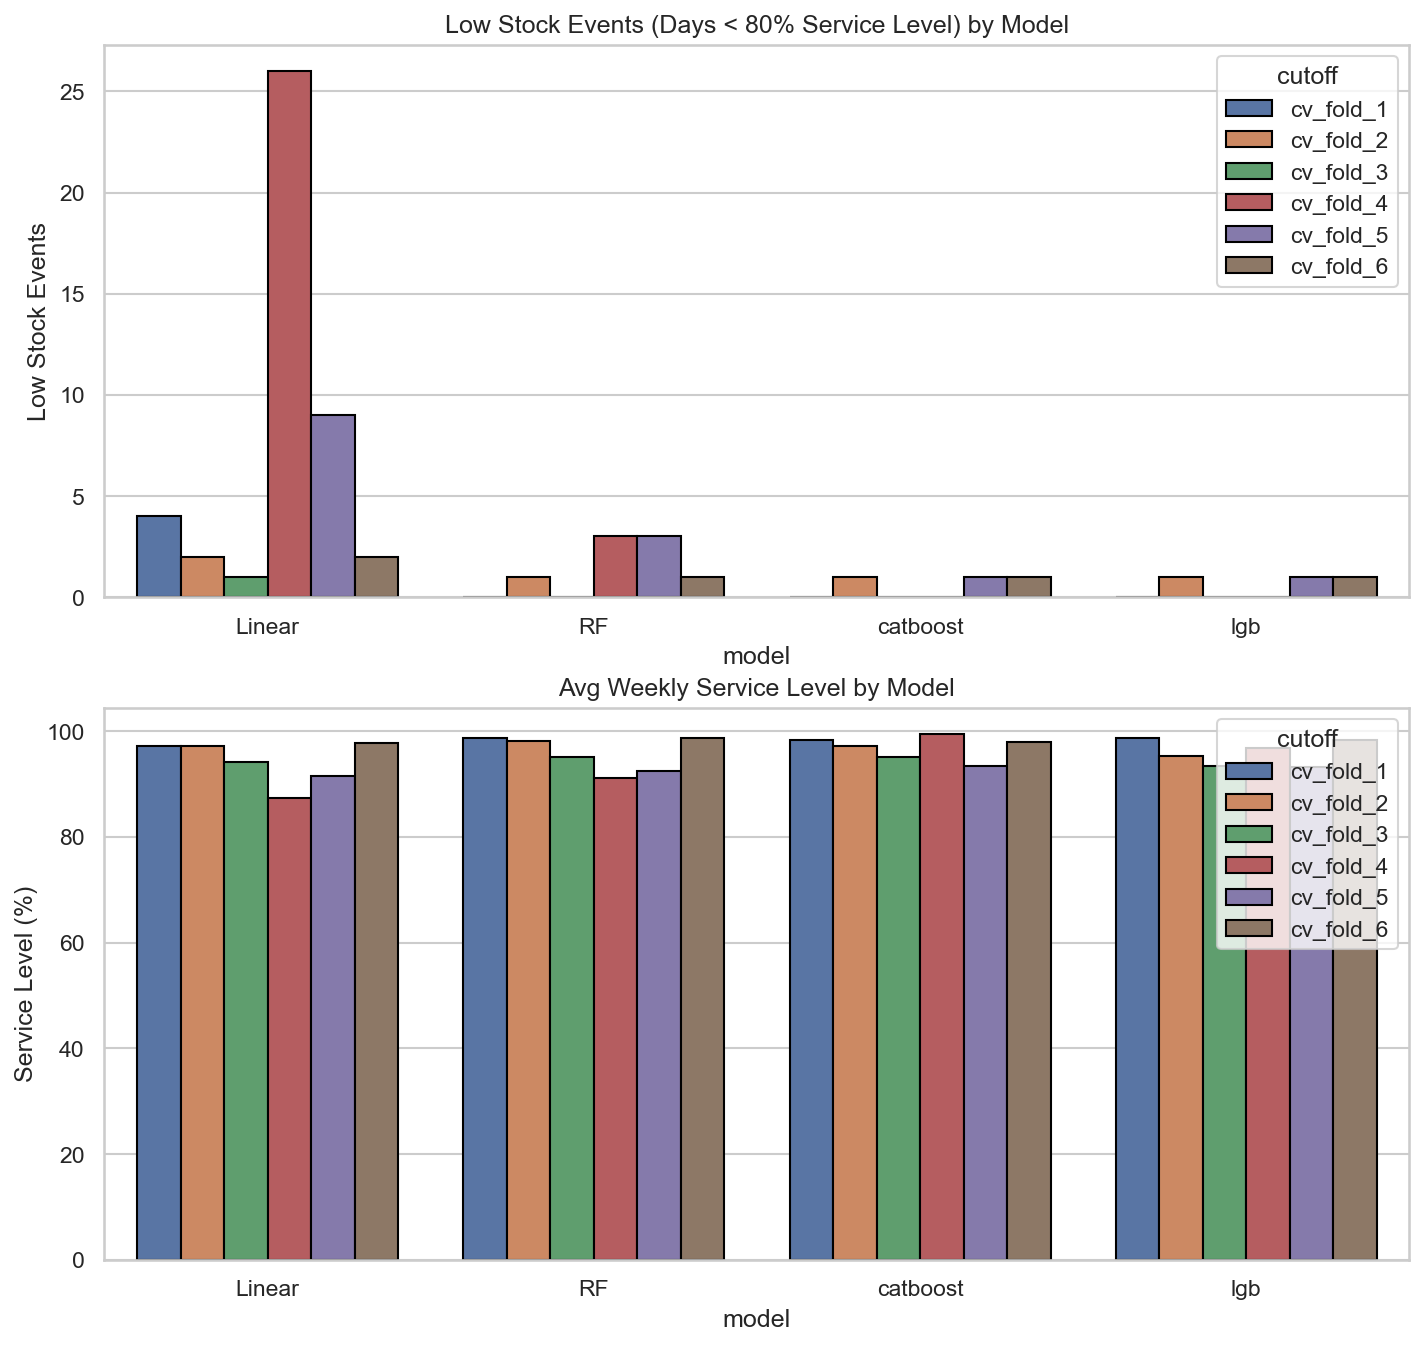

In [483]:
fig, ax = plt.subplots(figsize=(10,10),
                       nrows=2)

sns.barplot(service_lvl.reset_index(name='Service Level (%)'),
            x='model',
            y='Service Level (%)',
            hue='cutoff',
            edgecolor='black',
            ax=ax[1])\
                .set_title('Avg Weekly Service Level by Model')

sns.barplot(lo_stock.reset_index(name='Low Stock Events'),
            x='model',
            y='Low Stock Events',
            hue='cutoff',
            edgecolor='black',
            ax=ax[0])\
                .set_title('Low Stock Events (Days < 80% Service Level) by Model')